In [1]:
import os
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# solve the problem of "libdevice not found at ./libdevice.10.bc"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/r10222035/.conda/envs/tf2'

2024-09-30 16:32:51.596258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 16:32:51.679424: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Datasets

In [2]:
def get_sample_size(y):
    if len(y.shape) == 1:
        ns = (y == 1).sum()
        nb = (y == 0).sum()
    else:
        ns = (y.argmax(axis=1) == 1).sum()
        nb = (y.argmax(axis=1) == 0).sum()
    print(ns, nb)
    return ns, nb

In [3]:
ns, nb = 25000, 25000
X_s = np.load('DNN_features/resonant-abs_pairing.npy')[:ns]
X_b = np.load('DNN_features/pp6b-abs_pairing.npy')[:nb]

r_train, r_val, r_test = 0.7, 0.15, 0.15

X_s_train = X_s[:int(len(X_s)*r_train)]
X_s_val = X_s[int(len(X_s)*r_train):int(len(X_s)*(r_train+r_val))]
X_s_test = X_s[int(len(X_s)*(r_train+r_val)):]

X_b_train = X_b[:int(len(X_b)*r_train)]
X_b_val = X_b[int(len(X_b)*r_train):int(len(X_b)*(r_train+r_val))]
X_b_test = X_b[int(len(X_b)*(r_train+r_val)):]

X_train = np.concatenate((X_s_train, X_b_train), axis=0)
X_val = np.concatenate((X_s_val, X_b_val), axis=0)
X_test = np.concatenate((X_s_test, X_b_test), axis=0)

y_train = np.concatenate((np.ones(len(X_s_train)), np.zeros(len(X_b_train))), axis=0)
y_val = np.concatenate((np.ones(len(X_s_val)), np.zeros(len(X_b_val))), axis=0)
y_test = np.concatenate((np.ones(len(X_s_test)), np.zeros(len(X_b_test))), axis=0)

In [4]:
get_sample_size(y_train)
get_sample_size(y_val)
get_sample_size(y_test)

17500 17500
3750 3750
3750 3750


(3750, 3750)

In [5]:
BATCH_SIZE = 128
with tf.device('CPU'):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(y_train)).batch(BATCH_SIZE)

    valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    valid_dataset = valid_dataset.batch(BATCH_SIZE)

    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(BATCH_SIZE)

2024-09-30 16:32:57.313626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 16:32:57.923900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


# DNN

In [6]:
class DNN(tf.keras.Model):
    def __init__(self, name='DNN'):
        super(DNN, self).__init__(name=name)

        # self.bn = tf.keras.layers.BatchNormalization()

        self.network = tf.keras.Sequential([
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    @tf.function
    def call(self, inputs, training=False):

        output = self.network(inputs)

        return output

In [7]:
# Training parameters
train_epochs = 500
patience = 10
min_delta = 0.
learning_rate = 1e-3                                    
save_model_name = f'DNN_models/last_model/'

In [8]:
# Create the model  
model = DNN()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, verbose=1, patience=patience)
check_point    = tf.keras.callbacks.ModelCheckpoint(save_model_name, monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(train_dataset, validation_data=valid_dataset, epochs=train_epochs,
                    callbacks=[early_stopping,
                               check_point,
                               ]
                    )

Epoch 1/500


2024-09-30 16:33:00.264658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-30 16:33:00.269106: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f68c8018970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-30 16:33:00.269159: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-09-30 16:33:00.280433: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-30 16:33:00.409999: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


268/274 [============================>.] - ETA: 0s - loss: 1.5610 - accuracy: 0.5063
Epoch 1: val_loss improved from inf to 0.66725, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework

INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 6s 11ms/step - loss: 1.5459 - accuracy: 0.5065 - val_loss: 0.6673 - val_accuracy: 0.5692
Epoch 2/500
270/274 [============================>.] - ETA: 0s - loss: 0.7200 - accuracy: 0.5498
Epoch 2: val_loss did not improve from 0.66725
274/274 [==============================] - 2s 7ms/step - loss: 0.7197 - accuracy: 0.5500 - val_loss: 0.6677 - val_accuracy: 0.6277
Epoch 3/500
269/274 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.5626
Epoch 3: val_loss improved from 0.66725 to 0.66320, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.6917 - accuracy: 0.5626 - val_loss: 0.6632 - val_accuracy: 0.6124
Epoch 4/500
270/274 [============================>.] - ETA: 0s - loss: 0.6788 - accuracy: 0.5772
Epoch 4: val_loss improved from 0.66320 to 0.65171, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.6789 - accuracy: 0.5770 - val_loss: 0.6517 - val_accuracy: 0.6447
Epoch 5/500
273/274 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.6017
Epoch 5: val_loss improved from 0.65171 to 0.62705, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.6670 - accuracy: 0.6018 - val_loss: 0.6270 - val_accuracy: 0.6965
Epoch 6/500
270/274 [============================>.] - ETA: 0s - loss: 0.6504 - accuracy: 0.6341
Epoch 6: val_loss improved from 0.62705 to 0.61204, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.6502 - accuracy: 0.6343 - val_loss: 0.6120 - val_accuracy: 0.6996
Epoch 7/500
267/274 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.6670
Epoch 7: val_loss improved from 0.61204 to 0.58339, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.6294 - accuracy: 0.6676 - val_loss: 0.5834 - val_accuracy: 0.7304
Epoch 8/500
270/274 [============================>.] - ETA: 0s - loss: 0.6023 - accuracy: 0.7009
Epoch 8: val_loss improved from 0.58339 to 0.56117, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 9ms/step - loss: 0.6021 - accuracy: 0.7012 - val_loss: 0.5612 - val_accuracy: 0.7352
Epoch 9/500
272/274 [============================>.] - ETA: 0s - loss: 0.5757 - accuracy: 0.7247
Epoch 9: val_loss improved from 0.56117 to 0.51898, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.5754 - accuracy: 0.7249 - val_loss: 0.5190 - val_accuracy: 0.7739
Epoch 10/500
271/274 [============================>.] - ETA: 0s - loss: 0.5450 - accuracy: 0.7516
Epoch 10: val_loss improved from 0.51898 to 0.49289, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 11ms/step - loss: 0.5444 - accuracy: 0.7521 - val_loss: 0.4929 - val_accuracy: 0.7849
Epoch 11/500
273/274 [============================>.] - ETA: 0s - loss: 0.5178 - accuracy: 0.7688
Epoch 11: val_loss did not improve from 0.49289
274/274 [==============================] - 2s 7ms/step - loss: 0.5177 - accuracy: 0.7689 - val_loss: 0.5075 - val_accuracy: 0.7701
Epoch 12/500
267/274 [============================>.] - ETA: 0s - loss: 0.5016 - accuracy: 0.7789
Epoch 12: val_loss improved from 0.49289 to 0.46554, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.5010 - accuracy: 0.7793 - val_loss: 0.4655 - val_accuracy: 0.8009
Epoch 13/500
270/274 [============================>.] - ETA: 0s - loss: 0.4896 - accuracy: 0.7846
Epoch 13: val_loss did not improve from 0.46554
274/274 [==============================] - 2s 7ms/step - loss: 0.4900 - accuracy: 0.7843 - val_loss: 0.4865 - val_accuracy: 0.7888
Epoch 14/500
270/274 [============================>.] - ETA: 0s - loss: 0.4819 - accuracy: 0.7901
Epoch 14: val_loss improved from 0.46554 to 0.45981, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.4822 - accuracy: 0.7899 - val_loss: 0.4598 - val_accuracy: 0.8036
Epoch 15/500
271/274 [============================>.] - ETA: 0s - loss: 0.4740 - accuracy: 0.7958
Epoch 15: val_loss improved from 0.45981 to 0.45363, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.4743 - accuracy: 0.7956 - val_loss: 0.4536 - val_accuracy: 0.8099
Epoch 16/500
269/274 [============================>.] - ETA: 0s - loss: 0.4645 - accuracy: 0.7992
Epoch 16: val_loss improved from 0.45363 to 0.44702, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.4636 - accuracy: 0.7998 - val_loss: 0.4470 - val_accuracy: 0.8139
Epoch 17/500
268/274 [============================>.] - ETA: 0s - loss: 0.4572 - accuracy: 0.8031
Epoch 17: val_loss improved from 0.44702 to 0.44236, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 11ms/step - loss: 0.4582 - accuracy: 0.8024 - val_loss: 0.4424 - val_accuracy: 0.8185
Epoch 18/500
271/274 [============================>.] - ETA: 0s - loss: 0.4551 - accuracy: 0.8061
Epoch 18: val_loss improved from 0.44236 to 0.44060, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.4545 - accuracy: 0.8064 - val_loss: 0.4406 - val_accuracy: 0.8200
Epoch 19/500
271/274 [============================>.] - ETA: 0s - loss: 0.4485 - accuracy: 0.8081
Epoch 19: val_loss improved from 0.44060 to 0.43603, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.4482 - accuracy: 0.8084 - val_loss: 0.4360 - val_accuracy: 0.8240
Epoch 20/500
273/274 [============================>.] - ETA: 0s - loss: 0.4443 - accuracy: 0.8122
Epoch 20: val_loss did not improve from 0.43603
274/274 [==============================] - 2s 7ms/step - loss: 0.4444 - accuracy: 0.8121 - val_loss: 0.4400 - val_accuracy: 0.8176
Epoch 21/500
274/274 [==============================] - ETA: 0s - loss: 0.4400 - accuracy: 0.8154
Epoch 21: val_loss improved from 0.43603 to 0.42810, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.4400 - accuracy: 0.8154 - val_loss: 0.4281 - val_accuracy: 0.8211
Epoch 22/500
269/274 [============================>.] - ETA: 0s - loss: 0.4371 - accuracy: 0.8144
Epoch 22: val_loss improved from 0.42810 to 0.42121, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 11ms/step - loss: 0.4366 - accuracy: 0.8150 - val_loss: 0.4212 - val_accuracy: 0.8267
Epoch 23/500
267/274 [============================>.] - ETA: 0s - loss: 0.4344 - accuracy: 0.8195
Epoch 23: val_loss did not improve from 0.42121
274/274 [==============================] - 2s 7ms/step - loss: 0.4342 - accuracy: 0.8194 - val_loss: 0.4254 - val_accuracy: 0.8267
Epoch 24/500
273/274 [============================>.] - ETA: 0s - loss: 0.4297 - accuracy: 0.8203
Epoch 24: val_loss improved from 0.42121 to 0.41652, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.4297 - accuracy: 0.8203 - val_loss: 0.4165 - val_accuracy: 0.8245
Epoch 25/500
271/274 [============================>.] - ETA: 0s - loss: 0.4277 - accuracy: 0.8222
Epoch 25: val_loss did not improve from 0.41652
274/274 [==============================] - 2s 7ms/step - loss: 0.4277 - accuracy: 0.8222 - val_loss: 0.4862 - val_accuracy: 0.7781
Epoch 26/500
273/274 [============================>.] - ETA: 0s - loss: 0.4274 - accuracy: 0.8212
Epoch 26: val_loss improved from 0.41652 to 0.40878, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.4274 - accuracy: 0.8211 - val_loss: 0.4088 - val_accuracy: 0.8304
Epoch 27/500
267/274 [============================>.] - ETA: 0s - loss: 0.4228 - accuracy: 0.8235
Epoch 27: val_loss did not improve from 0.40878
274/274 [==============================] - 2s 7ms/step - loss: 0.4231 - accuracy: 0.8236 - val_loss: 0.4274 - val_accuracy: 0.8197
Epoch 28/500
273/274 [============================>.] - ETA: 0s - loss: 0.4228 - accuracy: 0.8237
Epoch 28: val_loss did not improve from 0.40878
274/274 [==============================] - 2s 7ms/step - loss: 0.4228 - accuracy: 0.8237 - val_loss: 0.4187 - val_accuracy: 0.8301
Epoch 29/500
266/274 [============================>.] - ETA: 0s - loss: 0.4195 - accuracy: 0.8265
Epoch 29: val_loss did not improve from 0.40878
274/274 [==============================] - 2s 7ms/step - loss: 0.4195 - accuracy: 0.8264 - val_loss: 0.4172 - val_accuracy: 0.8239
Epoch 30/500
271/274 [===============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.4193 - accuracy: 0.8252 - val_loss: 0.4074 - val_accuracy: 0.8319
Epoch 31/500
270/274 [============================>.] - ETA: 0s - loss: 0.4158 - accuracy: 0.8270
Epoch 31: val_loss did not improve from 0.40740
274/274 [==============================] - 2s 7ms/step - loss: 0.4155 - accuracy: 0.8271 - val_loss: 0.4122 - val_accuracy: 0.8332
Epoch 32/500
272/274 [============================>.] - ETA: 0s - loss: 0.4166 - accuracy: 0.8271
Epoch 32: val_loss did not improve from 0.40740
274/274 [==============================] - 2s 7ms/step - loss: 0.4163 - accuracy: 0.8272 - val_loss: 0.4365 - val_accuracy: 0.8069
Epoch 33/500
267/274 [============================>.] - ETA: 0s - loss: 0.4135 - accuracy: 0.8301
Epoch 33: val_loss did not improve from 0.40740
274/274 [==============================] - 2s 7ms/step - loss: 0.4134 - accuracy: 0.8303 - val_loss: 0.4668 - val_accuracy: 0.7888
Epoch 34/500
271/274 [===============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 11ms/step - loss: 0.4127 - accuracy: 0.8296 - val_loss: 0.4068 - val_accuracy: 0.8352
Epoch 35/500
267/274 [============================>.] - ETA: 0s - loss: 0.4116 - accuracy: 0.8294
Epoch 35: val_loss did not improve from 0.40679
274/274 [==============================] - 2s 7ms/step - loss: 0.4111 - accuracy: 0.8297 - val_loss: 0.4068 - val_accuracy: 0.8327
Epoch 36/500
268/274 [============================>.] - ETA: 0s - loss: 0.4092 - accuracy: 0.8317
Epoch 36: val_loss did not improve from 0.40679
274/274 [==============================] - 2s 7ms/step - loss: 0.4097 - accuracy: 0.8314 - val_loss: 0.4088 - val_accuracy: 0.8333
Epoch 37/500
274/274 [==============================] - ETA: 0s - loss: 0.4090 - accuracy: 0.8329
Epoch 37: val_loss did not improve from 0.40679
274/274 [==============================] - 2s 7ms/step - loss: 0.4090 - accuracy: 0.8329 - val_loss: 0.4127 - val_accuracy: 0.8207
Epoch 38/500
271/274 [===============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.4092 - accuracy: 0.8309 - val_loss: 0.4017 - val_accuracy: 0.8363
Epoch 40/500
270/274 [============================>.] - ETA: 0s - loss: 0.4086 - accuracy: 0.8314
Epoch 40: val_loss did not improve from 0.40166
274/274 [==============================] - 2s 7ms/step - loss: 0.4089 - accuracy: 0.8311 - val_loss: 0.4026 - val_accuracy: 0.8367
Epoch 41/500
269/274 [============================>.] - ETA: 0s - loss: 0.4062 - accuracy: 0.8340
Epoch 41: val_loss did not improve from 0.40166
274/274 [==============================] - 2s 7ms/step - loss: 0.4064 - accuracy: 0.8341 - val_loss: 0.4033 - val_accuracy: 0.8304
Epoch 42/500
268/274 [============================>.] - ETA: 0s - loss: 0.4067 - accuracy: 0.8324
Epoch 42: val_loss did not improve from 0.40166
274/274 [==============================] - 2s 7ms/step - loss: 0.4069 - accuracy: 0.8322 - val_loss: 0.4150 - val_accuracy: 0.8273
Epoch 43/500
270/274 [===============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.4042 - accuracy: 0.8334 - val_loss: 0.3962 - val_accuracy: 0.8375
Epoch 46/500
267/274 [============================>.] - ETA: 0s - loss: 0.4024 - accuracy: 0.8360
Epoch 46: val_loss did not improve from 0.39624
274/274 [==============================] - 2s 7ms/step - loss: 0.4031 - accuracy: 0.8359 - val_loss: 0.3991 - val_accuracy: 0.8365
Epoch 47/500
274/274 [==============================] - ETA: 0s - loss: 0.4047 - accuracy: 0.8318
Epoch 47: val_loss improved from 0.39624 to 0.39252, saving model to DNN_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 10ms/step - loss: 0.4047 - accuracy: 0.8318 - val_loss: 0.3925 - val_accuracy: 0.8367
Epoch 48/500
268/274 [============================>.] - ETA: 0s - loss: 0.4070 - accuracy: 0.8325
Epoch 48: val_loss did not improve from 0.39252
274/274 [==============================] - 2s 7ms/step - loss: 0.4070 - accuracy: 0.8324 - val_loss: 0.4072 - val_accuracy: 0.8320
Epoch 49/500
273/274 [============================>.] - ETA: 0s - loss: 0.4012 - accuracy: 0.8349
Epoch 49: val_loss did not improve from 0.39252
274/274 [==============================] - 2s 7ms/step - loss: 0.4011 - accuracy: 0.8349 - val_loss: 0.3997 - val_accuracy: 0.8355
Epoch 50/500
268/274 [============================>.] - ETA: 0s - loss: 0.4040 - accuracy: 0.8326
Epoch 50: val_loss did not improve from 0.39252
274/274 [==============================] - 2s 7ms/step - loss: 0.4038 - accuracy: 0.8324 - val_loss: 0.4058 - val_accuracy: 0.8331
Epoch 51/500
271/274 [===============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533310>, 140103584905936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c685038b0>, 140105591527408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68533f10>, 140103584472080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684fdcd0>, 140103584470800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684a6bb0>, 140103584508704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684b9c70>, 140103584509184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c684cdb80>, 140103584469840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6c68461c70>, 140103584509504), {}).


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


INFO:tensorflow:Assets written to: DNN_models/last_model/assets


274/274 [==============================] - 3s 11ms/step - loss: 0.4021 - accuracy: 0.8345 - val_loss: 0.3880 - val_accuracy: 0.8389
Epoch 52/500
273/274 [============================>.] - ETA: 0s - loss: 0.4025 - accuracy: 0.8344
Epoch 52: val_loss did not improve from 0.38800
274/274 [==============================] - 2s 7ms/step - loss: 0.4022 - accuracy: 0.8345 - val_loss: 0.4287 - val_accuracy: 0.8247
Epoch 53/500
268/274 [============================>.] - ETA: 0s - loss: 0.4019 - accuracy: 0.8352
Epoch 53: val_loss did not improve from 0.38800
274/274 [==============================] - 2s 7ms/step - loss: 0.4025 - accuracy: 0.8351 - val_loss: 0.4123 - val_accuracy: 0.8257
Epoch 54/500
268/274 [============================>.] - ETA: 0s - loss: 0.4023 - accuracy: 0.8347
Epoch 54: val_loss did not improve from 0.38800
274/274 [==============================] - 2s 7ms/step - loss: 0.4026 - accuracy: 0.8346 - val_loss: 0.4022 - val_accuracy: 0.8339
Epoch 55/500
272/274 [===============

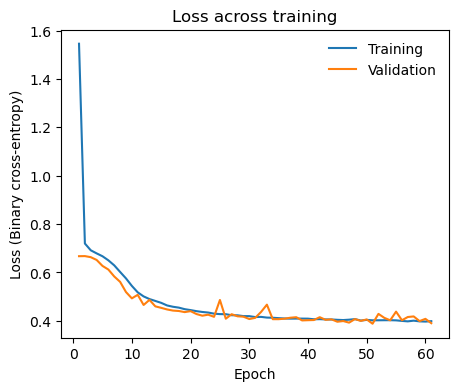

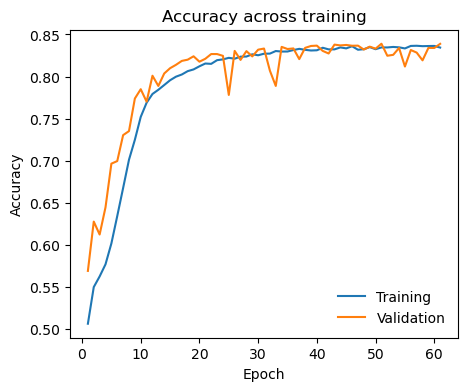

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

x = range(1, len(history.history['loss']) + 1)
y_train = history.history['loss']
y_validation = history.history['val_loss']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Loss across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Binary cross-entropy)')
ax.legend(frameon=False)

plt.savefig('../figures/DNN_loss_resonant.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(5, 4))

x = range(1, len(history.history['accuracy']) + 1)
y_train = history.history['accuracy']
y_validation = history.history['val_accuracy']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Accuracy across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(frameon=False)

plt.savefig('../figures/DNN_accuracy_resonant.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Training results

In [10]:
save_model_name = f'DNN_models/last_model/'
loaded_model = tf.keras.models.load_model(save_model_name)

In [11]:
results = loaded_model.evaluate(test_dataset)
print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

59/59 [==============================] - 0s 3ms/step - loss: 0.3957 - accuracy: 0.8368
Testing Loss = 0.396, Testing Accuracy = 0.837


In [12]:
def get_highest_accuracy(y_true, y_pred):
    _, _, thresholds = roc_curve(y_true, y_pred)
    # compute highest accuracy
    thresholds = np.array(thresholds)
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0, 100, 1001))
    accuracy_scores = []
    for threshold in thresholds:
        accuracy_scores.append(accuracy_score(y_true, y_pred>threshold))

    accuracies = np.array(accuracy_scores)
    return accuracies.max()

235/235 [==============================] - 0s 1ms/step


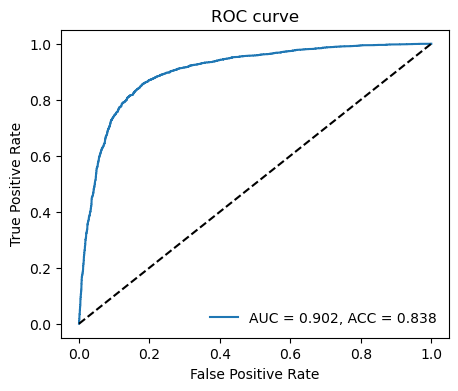

In [13]:
# Plot ROC curve
fig, ax = plt.subplots(1, 1, figsize=(5, 4))


X, y = X_test, y_test
y_pred = loaded_model.predict(X)
fpr, tpr, thresholds = roc_curve(y, y_pred)
auc = roc_auc_score(y, y_pred)

acc = get_highest_accuracy(y, y_pred)
ax.plot(fpr, tpr, label=f'AUC = {auc:.3f}, ACC = {acc:.3f}')


ax.plot([0, 1], [0, 1], 'k--')

# # log scale
# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')
ax.legend(frameon=False)

plt.savefig('../figures/DNN_roc_resonant.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

782/782 [==============================] - 2s 3ms/step


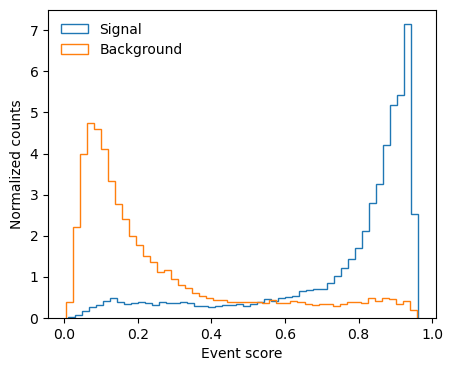

In [14]:
# plot DNN score distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

y_pred_s = loaded_model.predict(X_s)
y_pred_b = loaded_model.predict(X_b)

ax.hist(y_pred_s, bins=50, histtype='step', label='Signal', density=True)
ax.hist(y_pred_b, bins=50, histtype='step', label='Background', density=True)

ax.set_xlabel('Event score')
ax.set_ylabel('Normalized counts')
ax.legend(frameon=False, loc='upper left')

plt.savefig('../figures/DNN_event_score_resonant.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()